In [48]:
from os import path

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

import json

# Requires skimage version >= 0.16.2
# from skimage.draw import line, ellipse
import skimage.draw
import skimage.morphology

from scipy.ndimage import gaussian_filter
import scipy.io

# Parameters

In [49]:
# Names of sample files: sample_names-xxxxx
sample_names = 'beads'

# Record path
record_dir = path.join('..', 'data', 'model-2.1', 'ground-truths')

In [69]:
plane_dims = np.array([684, 486])

# Size of each pixel in um
scale = np.array([1.5, 1.5])

# Number of planes to generate
N = 5

# Shapes to incorporate
shapes = np.array(['line', 'circle', 'ellipse'])

# Sparsity ranges for each shape
sparsity_ranges = {
              'line': np.array([1e-3, 2e-3]),
              'curve': np.array([7e-6, 2e-4]),
              'circle': np.array([8e-4, 4e-3]),
              'filled_circle': np.array([0, 0]),
              'ellipse': np.array([8e-4, 4e-3]),
              'filled_ellipse': np.array([1e-6, 1e-5])
             }

# Temporary sparsity ranges for convenience
num_pixels = np.prod(plane_dims)
sparsity_ranges = {
              'line': np.array([1, 3]) / num_pixels,
              'curve': np.array([1, 2]) / num_pixels,
              'circle': np.array([.5, 2]) / num_pixels,
              'filled_circle': np.array([.5, 1.5]) / num_pixels,
              'ellipse': np.array([.5, 2]) / num_pixels,
              'filled_ellipse': np.array([.5, 1.5]) / num_pixels
             }



# Properties, arrays representing ranges
# Thickness is defined as a radius
properties = {
         'line': {'thickness': np.array([1, 5])},
         'curve': {'curvature': np.array([0, 0]),
                   'thickness': np.array([1, 3])}, 
         'circle': {'radius': np.array([10, 100]),
                    'thickness': np.array([1, 5])},
         'filled_circle': {'radius': np.array([0, 0])},
         'ellipse': {'semi_major_axis': np.array([30, 50]),
                     'semi_minor_axis': np.array([10, 20]),
                     'thickness': np.array([1, 5])},
         'filled_ellipse': {'y_radius': np.array([0, 0]),
                            'x_radius': np.array([0, 0])}
        }
# Radius of minimum separation between beads in pixels 
min_sep = np.array([3, 3]) / scale

# Range of bead radii in pixels
bead_sizes = np.array([3, 3]) / scale              

# Square size in pixels
square_size = 2

# FWHM in pixels of 2D Gaussian convolution for blurring
fwhm_pixels = np.array([2, 2])

# Helper Functions

In [70]:
def create_mask(indices, shape):
    """ 
    Converts index array to boolean numpy array. 
    Index array should not be a numpy array. 
    """
    mask = np.zeros(shape)
    mask[indices] = 1
    return mask

# Plane Generator

In [71]:
class PlaneGenerator():
    """
    Constructs a generator to build planes with random points and lines.
    
    Attributes:
        - plane_dims: (y, x) dimensions in pixels
    """
    def __init__(self, plane_dims, shapes, sparsity_ranges, properties):
        """
        Inputs:
        - plane_dims: (y, x) in pixels
        - shapes: string array of desired shapes to incorporate
        - sparsity_ranges: dictionary of sparsity ranges for each shape
        - properties: dictionary describing desired properties for each shape

        """
        self.plane_dims = plane_dims
        self.shapes = shapes
        self.sparsity_ranges = sparsity_ranges
        self.properties = properties
        
    def generate(self, N):
        """
        Generates planes to store into self.plane_set.
        
        Inputs:
        - N: Number of planes with shape (y, x) to generate
        """
        
        self.N = N
        self.bead_sizes = bead_sizes
        self.min_sep = min_sep
        
        Y, X = self.plane_dims
        self.plane_set = np.zeros((N, Y, X), dtype=np.float32)
        
        for n in range(N):
            self.plane_set[n] = self._generate_plane()
            
    
    def visualize(self, num_planes):
        """
        Visualizes random planes from plane_set.
        """
        batch = np.random.choice(self.N, num_planes, replace=False)
        
        for i in batch:
            plt.imshow(self.plane_set[i])
            plt.show()
        
    def cast_float16(self):
        """
        For casting to float16 before writing to file
        """
        self.plane_set = self.plane_set.astype(np.float16)
        
    def write(self, record_dir):
        """
        Writes all planes, one by one, in plane_set to filenames in record_dir.
        """
        for i in range(self.N):
            filename = sample_names + '-%.5d' % i + '.tfrecord'
            record_file = path.join(record_dir, filename)
            with tf.io.TFRecordWriter(record_file) as writer:
                tf_example = self._create_example(self.plane_set[i])
                writer.write(tf_example.SerializeToString())
                

    def _generate_plane(self):
        """
        Generates a single plane, returning array of shape (y, x).
        """
        Y, X = self.plane_dims
        num_pixels = Y*X
        plane = np.zeros((Y, X))
        
        sparsities = {}
        num_shapes = {}

        for shape in self.shapes:
            sparsities[shape] = np.random.uniform(*self.sparsity_ranges[shape])
            num_shapes[shape] = int(num_pixels * sparsities[shape])
        
        for shape, num in num_shapes.items():
            self._generate_shapes(plane, shape, num)
            
        return plane
        
        
    def _generate_shapes(self, plane, shape, num):
        if shape == 'line':
            self._generate_lines(plane, num)
        if shape == 'circle':
            self._generate_circles(plane, num)
        if shape == 'ellipse':
            self._generate_ellipses(plane, num)

            
    def _generate_lines(self, plane, num):
        Y, X = self.plane_dims
        for _ in range(num):
            y1 = np.random.randint(0, Y)
            x1 = np.random.randint(0, X)
            y2 = np.random.randint(0, Y)
            x2 = np.random.randint(0, X)
            thickness = np.random.uniform(*self.properties['line']['thickness'])

            indices = skimage.draw.line(y1, x1, y2, x2)
            mask = create_mask(indices, self.plane_dims)
            
            # Adding thickness
            struct = skimage.morphology.disk(radius=thickness)
            mask = skimage.morphology.binary_dilation(mask, struct)
            
            plane[mask] = 1
            
    def _generate_circles(self, plane, num):
        Y, X = self.plane_dims
        for _ in range(num):
            y = np.random.randint(0, Y)
            x = np.random.randint(0, X)
            radius = np.random.randint(*self.properties['circle']['radius'])
            thickness = np.random.uniform(*self.properties['circle']['thickness'])
            
            indices = skimage.draw.circle_perimeter(y, x, radius, shape=(Y, X))
            mask = create_mask(indices, self.plane_dims)
            struct = skimage.morphology.disk(radius=thickness)
            mask = skimage.morphology.binary_dilation(mask, struct)
            plane[mask] = 1
    
    def _generate_ellipses(self, plane, num):
        Y, X = self.plane_dims
        for _ in range(num):
            y = np.random.randint(0, Y)
            x = np.random.randint(0, X)
            semi_major_axis = np.random.randint(*self.properties['ellipse']['semi_major_axis'])
            semi_minor_axis = np.random.randint(*self.properties['ellipse']['semi_minor_axis'])
            thickness = np.random.uniform(*self.properties['ellipse']['thickness'])
            orientation = np.random.uniform(0, np.pi)

            indices = skimage.draw.ellipse_perimeter(y, x, semi_major_axis, 
                                                     semi_minor_axis, orientation, shape=(Y, X))
            mask = create_mask(indices, self.plane_dims)
            struct = skimage.morphology.disk(radius=thickness)
            mask = skimage.morphology.binary_dilation(mask, struct)
            plane[mask] = 1
        
    def _create_example(self, plane):
        """
        Creates and returns tf.Example from a given plane.
        """
        plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
        feature = {
            'plane': plane_feature
        }
        return tf.train.Example(features=tf.train.Features(feature=feature))

In [76]:
pg = PlaneGenerator(plane_dims, shapes, sparsity_ranges, properties)
pg.generate(N)

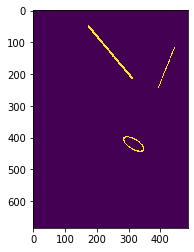

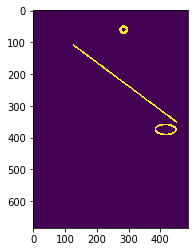

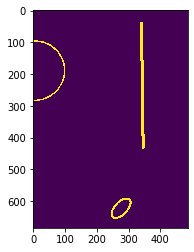

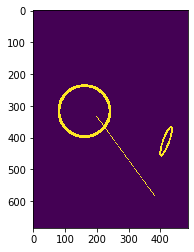

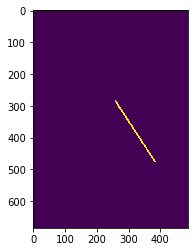

In [77]:
pg.visualize(5)

In [ ]:
pg.cast_float16()
pg.write(record_dir)

In [ ]:
                    
#     def _generate_line_uniform(self, plane):
#         """
#         Add random line to plane. Chooses two points from uniform distribution to generate a line.
        
#         Inputs:
#         - plane: plane to add line to
#         """
#         Y, X = self.plane_dims
#         y1 = np.random.randint(0, Y)
#         x1 = np.random.randint(0, X)
        
#         y2 = np.random.randint(0, Y)
#         x2 = np.random.randint(0, X)
        
#         lin = line(y1, x1, y2, x2)
#         plane[lin] = 1


        
        #     def _generate_bead_uniform(self, plane, occupied):
#         """
#         Uniform randomly generates beads separated in space.
        
#         Inputs:
#         - plane: plane to add points to.
#         - occupied: Numpy array to enforce min separation in each plane (y, x).
#         """
#         Y, X = self.plane_dims
#         y = np.random.randint(0, Y)
#         x = np.random.randint(0, X)
#         while occupied[y, x] == 1:
#             y = np.random.randint(0, Y)
#             x = np.random.randint(0, X)
        
#         plane[y, x] = 1
#         self._occupy_bead(occupied, (y, x))
        
    
    
    
        
                
#     def _generate_plane(self, pt_sparsities, line_sparsities):
#         """
#         Generates a single plane, returning array of shape (y, x).
#         Sparsities are chosen uniformly.
#         """
        
#         Y, X = self.plane_dims
#         plane = np.zeros((Y, X))
#         occupied = np.zeros((Y, X))
        
#         pt_sparsity = np.random.uniform(*pt_sparsities)
#         line_sparsity = np.random.uniform(*line_sparsities)
        
#         num_pts = int(Y*X*pt_sparsity)
#         num_lines = int(Y*X*line_sparsity)
        
#         for i in range(num_pts):
#             self._generate_square_uniform(plane, occupied)
        
#         for i in range(num_lines):
#             self._generate_line_uniform(plane)
        
#         # 2D Gaussian blurring
#         sigmas = fwhm_pixels / np.sqrt(8 * np.log(2)) 
#         plane = gaussian_filter(plane, sigmas)
        
#         # Renormalize
#         plane_max = np.max(plane)
#         plane_min = np.min(plane)
#         plane = (plane - plane_min) / (plane_max - plane_min)
        
#         return plane

#     
#     def _generate_bead_uniform(self, plane, occupied):
#         """
#         Uniform randomly generates beads separated in space.
        
#         Inputs:
#         - plane: plane to add points to.
#         - occupied: Numpy array to enforce min separation in each plane (y, x).
#         """
#         Y, X = self.plane_dims
#         y = np.random.randint(0, Y)
#         x = np.random.randint(0, X)
#         while occupied[y, x] == 1:
#             y = np.random.randint(0, Y)
#             x = np.random.randint(0, X)
        
#         plane[y, x] = 1
#         self._occupy_bead(occupied, (y, x))
        
#     def _generate_square_uniform(self, plane, occupied):
#         """
#         Uniform randomly generates 2x2 squares centered at the top left.
#         """
        
#         Y, X = self.plane_dims
#         y = np.random.randint(0, Y-1)
#         x = np.random.randint(0, X-1)
#         while np.sum(occupied[y:y+2, x:x+2]) > 0:
#             y = np.random.randint(0, Y-1)
#             x = np.random.randint(0, X-1)
        
#         plane[y:y+2, x:x+2] = 1
#         # For now, using min_sep to determine occupied
#         self._occupy_bead(occupied, (y, x))
            
#     def _generate_pt_uniform(self, plane, occupied):
#         """
#         Adds unique random point to plane. Point is uniformly distributed.
        
#         Inputs:
#         - plane: plane to add points to.
#         - occupied: Numpy array to enforce min separation in each plane (y, x).
#         """
#         Y, X = self.plane_dims
#         y = np.random.randint(0, Y)
#         x = np.random.randint(0, X)
        
#         while occupied[y, x] == 1:
#             y = np.random.randint(0, Y)
#             x = np.random.randint(0, X)
        
#         occupied[y, x] = 1
#         plane[y, x] = 1
    
#     def _generate_line_uniform(self, plane):
#         """
#         Add random line to plane. Chooses two points from uniform distribution to generate a line.
        
#         Inputs:
#         - plane: plane to add line to
#         """
#         Y, X = self.plane_dims
#         y1 = np.random.randint(0, Y)
#         x1 = np.random.randint(0, X)
        
#         y2 = np.random.randint(0, Y)
#         x2 = np.random.randint(0, X)
        
#         lin = line(y1, x1, y2, x2)
#         plane[lin] = 1
        
        
#     def _occupy_bead(self, occupied, center):
#         """
#         Enforces min separation between beads at a center.
        
#          Inputs:
#         - occupied: Numpy array of shape (y, x) with ones to specify which points are occupied
#         - center: Center, (y, x)
#         """
#         Y, X = self.plane_dims
#         y, x = center
        
#         sep_idx = min_sep
#         y_sep, x_sep = sep_idx
#         elip = ellipse(y, x, y_sep, x_sep, shape=(Y, X))
        
#         y_elip, x_elip = elip
        
#         occupied[y_elip, x_elip] = 1
